In [ ]:
#!pip install -r requirements.txt

In [3]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

In [4]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('../data/stores.csv')
df_items = pd.read_csv('../data/items.csv')
df_transactions = pd.read_csv('../data/transactions.csv')
df_oil = pd.read_csv('../data/oil.csv')
df_holidays_events = pd.read_csv('../data/holidays_events.csv')
# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('../data/train.csv', nrows=2e6)

In [3]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
store_ids

array([24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51])

In [4]:
# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 1000000

# Read the csv file in chunks
for chunk in pd.read_csv('data/train.csv', chunksize=chunk_size):
  # Filter the chunk for the desired store IDs
  chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
  # Append the filtered chunk to the list
  filtered_chunks.append(chunk_filtered)
  # Optional: Delete the chunk to free up memory
  del chunk

# Concatenate all the filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

/var/folders/cg/_vgckz8568g7vn87wmg8bhkm0000gn/T/ipykernel_15167/1412416196.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('data/train.csv', chunksize=chunk_size):


In [5]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.0,NaN
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN


In [6]:
df_train.shape

(22941656, 6)

In [7]:
# Plotting the number of items per family (for top 3 families only)
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['family', 'Item Count']
top_3_families = items_per_family.head(3)

items_per_family.head(10)

,family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446
3,PRODUCE,306
4,DAIRY,242
5,PERSONAL CARE,153
6,BREAD/BAKERY,134
7,HOME CARE,108
8,DELI,91
9,MEATS,84


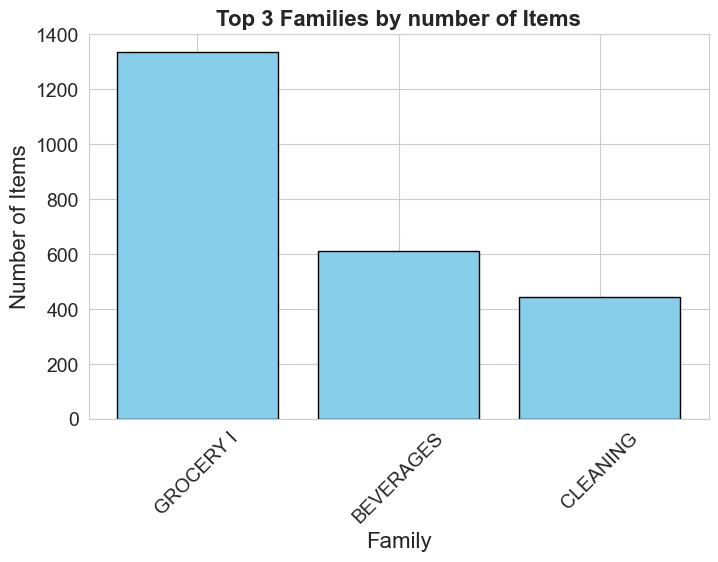

In [8]:
# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['family'], top_3_families['Item Count'], color ='skyblue', edgecolor ='black')
plt.xlabel('Family', fontsize = 16)
plt.ylabel('Number of Items', fontsize = 16)
plt.title('Top 3 Families by number of Items', fontsize = 16, fontweight ='bold')
plt.xticks(fontsize = 14, rotation=45)
plt.yticks(fontsize = 14)
plt.show()

In [9]:
# Filter train data also
item_ids = df_items[df_items['family'].isin(top_3_families['family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

In [10]:
df_train.shape

(14745768, 6)

# Preprocessing
## Missing Values

In [11]:
# Checking missing values (handling missing data is important for accurate analysis and modeling)
df_train.isnull().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

#### Promotions are rather rare and onpromotion column contains many NAN, which we will first replace with True/False then converted to Binary.

In [12]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)
df_train['onpromotion'] = df_train['onpromotion'].astype('int64')
df_train.isnull().sum()

/var/folders/cg/_vgckz8568g7vn87wmg8bhkm0000gn/T/ipykernel_15167/758945856.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64

In [13]:
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [14]:
df_transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [15]:
df_items.isnull().sum()

item_nbr      0
family        0
class         0
perishable    0
dtype: int64

In [16]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [17]:
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

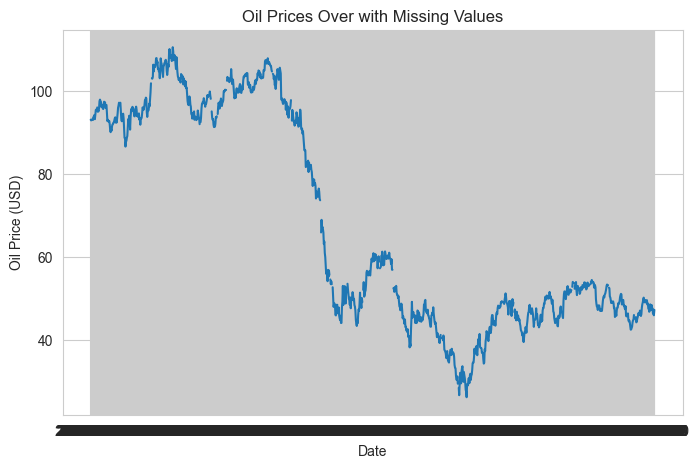

In [18]:
plt.figure(figsize=(8,5))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.title('Oil Prices Over with Missing Values')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True)
plt.show()

#### oil prices usually don't change dramatically from one day to the next,the common ways to fill missing values is forward fill and backward fill to ensure that there is no missing values after calculation.

In [19]:
# First, forward fill to carry the last known price forward
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')

# Then, backward fill in case there were missing values at the very beginning (top of the dataset)
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

# Finally, you can double-check that no missing values remain
missing_count = df_oil['dcoilwtico'].isnull().sum()
print(f"Missing values after filling: {missing_count}")

Missing values after filling: 0


/var/folders/cg/_vgckz8568g7vn87wmg8bhkm0000gn/T/ipykernel_15167/2030409964.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
/var/folders/cg/_vgckz8568g7vn87wmg8bhkm0000gn/T/ipykernel_15167/2030409964.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')


In [20]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

#### Now we can see how oil price changes over time after we handle missing values.

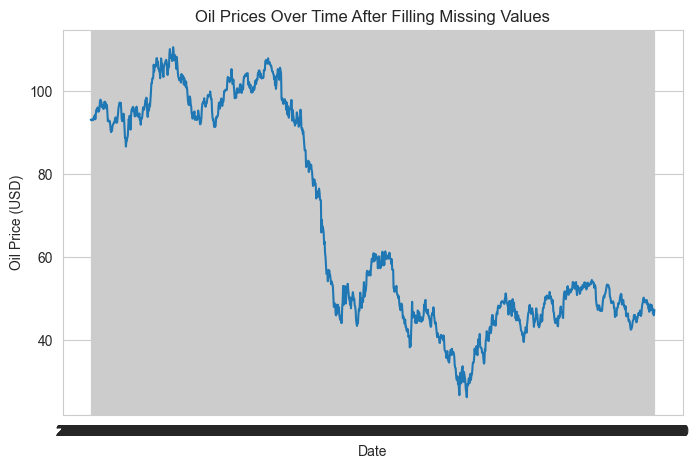

In [21]:
plt.figure(figsize=(8,5))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.title('Oil Prices Over Time After Filling Missing Values')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True)
plt.show()

## Handling Outliers
### Negative values

In [22]:
# Checking for Negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,0
54236,309805,2013-01-09,35,1079215,-8.0,0
64452,382905,2013-01-11,27,1097187,-20.0,0
96414,564108,2013-01-15,51,627885,-36.0,0
132903,787522,2013-01-21,24,211205,-5.0,0


In [23]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

### Detect outliers for extreamly high sales.

In [24]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
  # Compute mean and standard deviation for each store-item group
  mean_sales = group['unit_sales'].mean()
  std_sales = group['unit_sales'].std()
  # Calculate Z-score (avoiding division by zero for standard deviation)
  group['store_item_zscore'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
  return group

# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore, include_groups=False)

#df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g. Z-score > 5)
outliers = df_train_grouped[df_train_grouped['store_item_zscore'] > 5]
# Print outliers
print(f"Number of Outliers detected: {len(outliers)}")
outliers.head()

Number of Outliers detected: 48485


,id,date,unit_sales,onpromotion,store_item_zscore
188,15666702,2013-12-18,14.0,0,7.946399
286,59775862,2015-10-20,14.0,0,5.822016
289,60322807,2015-10-26,19.0,0,8.276173
721,15717753,2013-12-19,27.0,0,6.642670
770,18886543,2014-02-13,22.0,0,5.154400


#### There are many outliers but they don't look like errors. These are just big sales.

# Feature Engineering

In [25]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


In [26]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


In [27]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [28]:
# Now we have all dates and corresponding sales for them. Let's replace the original dataframe.
df_train = df_filled
del df_filled

In [29]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [30]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())


In [31]:
df_train.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,0.0,2013,1,2,2,NaN
1,24,105574,2013-01-03,59692.0,1.0,0.0,2013,1,3,3,NaN
2,24,105574,2013-01-04,99664.0,3.0,0.0,2013,1,4,4,NaN
3,24,105574,2013-01-05,140805.0,4.0,0.0,2013,1,5,5,NaN
4,24,105574,2013-01-06,182800.0,7.0,0.0,2013,1,6,6,NaN


# Visualizing Time Series Data

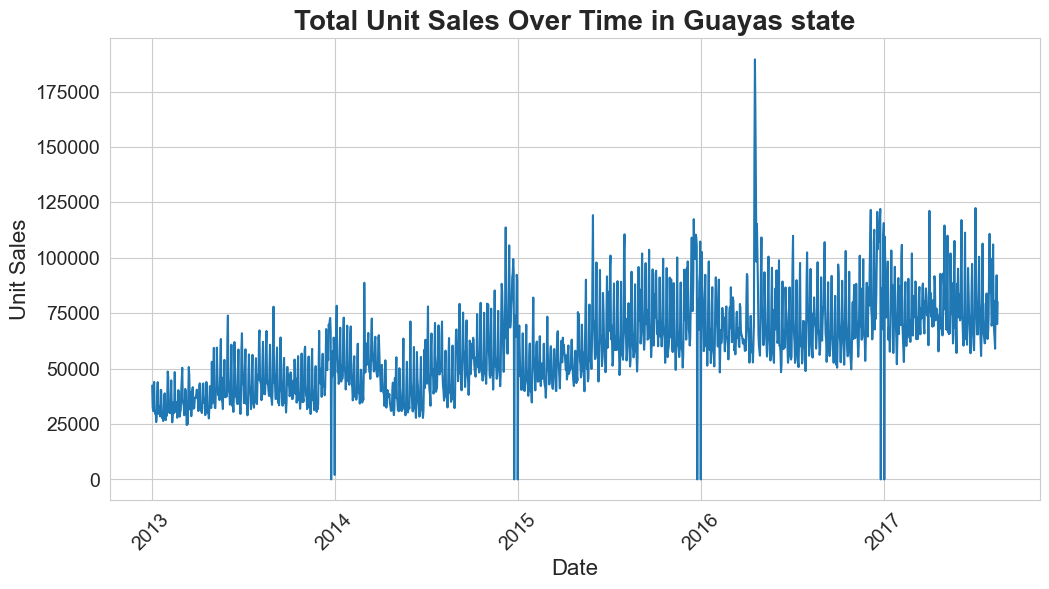

In [32]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

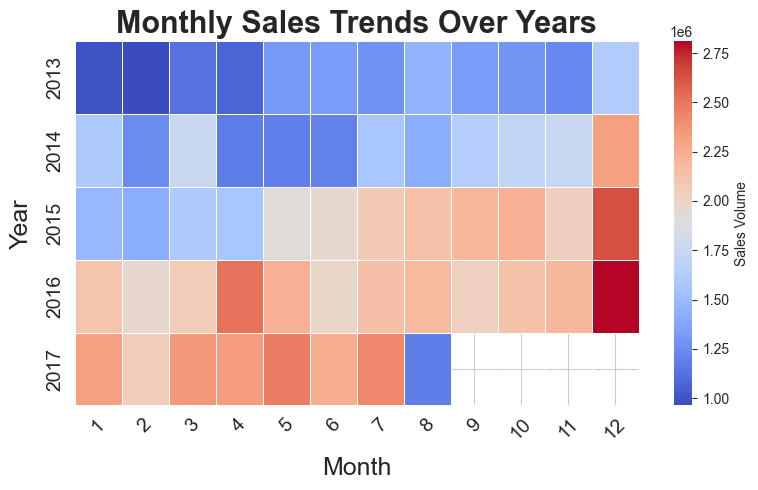

In [33]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

### Sales Trends Over Time: We will plot the sales day-by-day. And also a smoothed rolling average to remove daily noise.

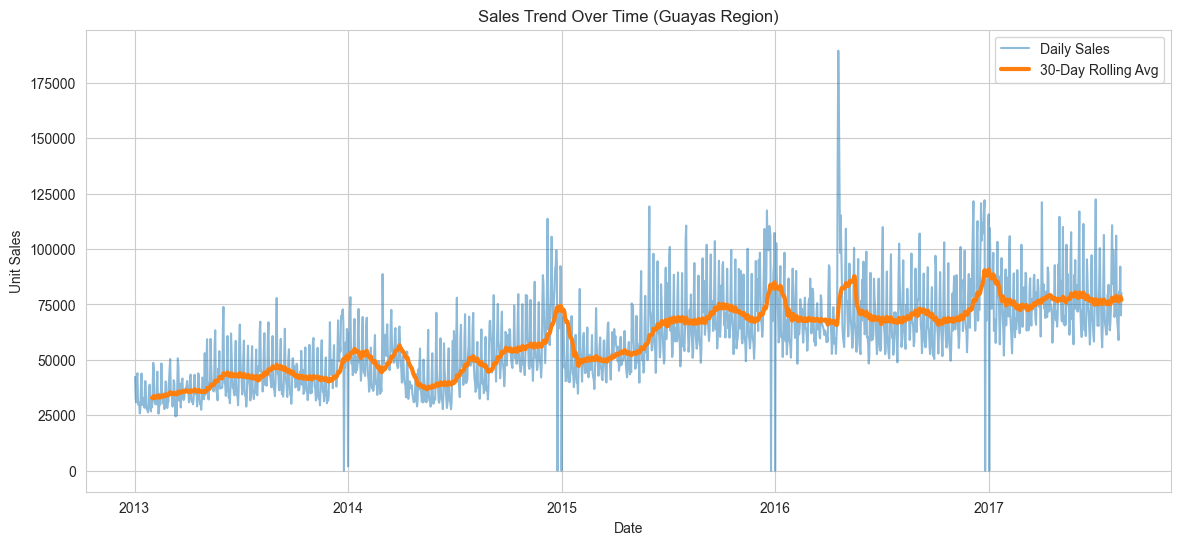

In [34]:
# Total daily sales in Guayas
sales_guayas = df_train.groupby('date')['unit_sales'].sum()

# Plot raw daily sales + rolling average
plt.figure(figsize=(14,6))
plt.plot(sales_guayas, label='Daily Sales', alpha=0.5)
plt.plot(sales_guayas.rolling(window=30).mean(), label='30-Day Rolling Avg', linewidth=3)
plt.title('Sales Trend Over Time (Guayas Region)')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

#### This shows the general business health.

### Weekly and Monthly Patterns: We will analyze and plot:
Average sales per day of week (Mon, Tue, ... Sun)
Average sales per month (Jan, Feb, ... Dec)

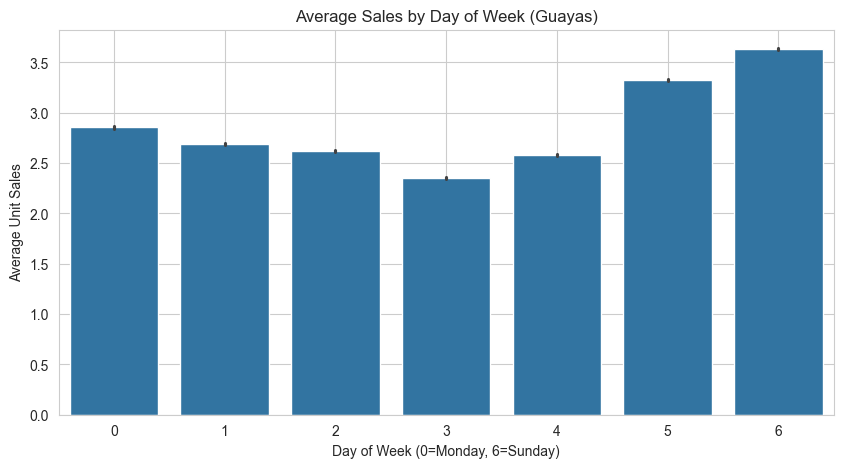

In [35]:
# Average sales by day of week
df_train['day_of_week'] = df_train['date'].dt.dayofweek

plt.figure(figsize=(10,5))
sns.barplot(x='day_of_week', y='unit_sales', data=df_train, estimator=np.mean)
plt.title('Average Sales by Day of Week (Guayas)')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Unit Sales')
plt.grid(True)
plt.show()

#### Saturday and Sunday are the peaks → strong weekend shopping behavior!

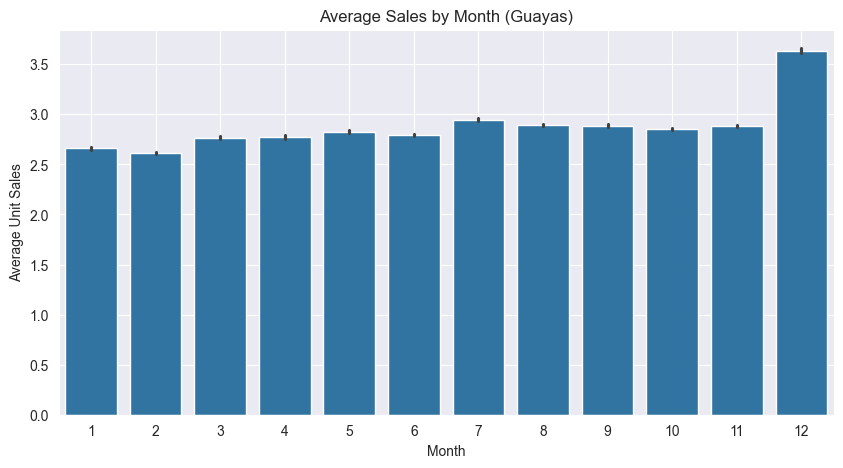

In [51]:
# Monthly Pattern Code:
# Average sales by month
df_train['month'] = df_train['date'].dt.month

plt.figure(figsize=(10,5))
sns.barplot(x='month', y='unit_sales', data=df_train, estimator=np.mean)
plt.title('Average Sales by Month (Guayas)')
plt.xlabel('Month')
plt.ylabel('Average Unit Sales')
plt.grid(True)
plt.show()

#### December is much higher → Christmas/New Year effect 🎄

#### Promotions Impact: We will compare sales with promotion ON vs OFF

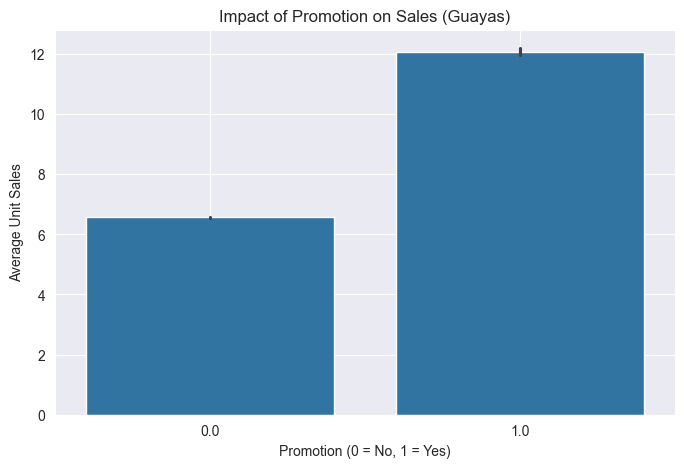

In [53]:
# Average sales with and without promotion
plt.figure(figsize=(8,5))
sns.barplot(x='onpromotion', y='unit_sales', data=df_train, estimator=np.mean)
plt.title('Impact of Promotion on Sales (Guayas)')
plt.xlabel('Promotion (0 = No, 1 = Yes)')
plt.ylabel('Average Unit Sales')
plt.grid(True)
plt.show()

#### promotion sales are much higher → Promotions are effective!

#### Influence of Oil price

/var/folders/cg/_vgckz8568g7vn87wmg8bhkm0000gn/T/ipykernel_6053/3746388369.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


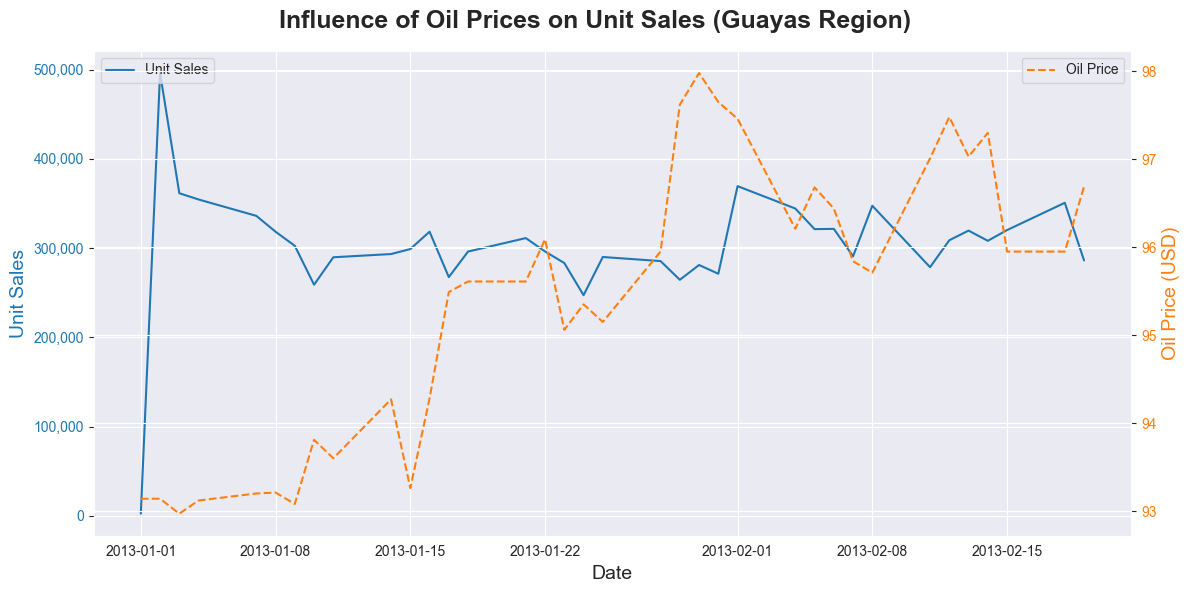

In [65]:
#Ensure 'date' columns are datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

# 3. Fill missing oil prices
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# 4. Aggregate sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# 5. Merge sales with oil price
merged_data = pd.merge(sales_by_date, df_oil, on='date', how='left')
merged_data.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# 6. Drop rows where oil price is still NaN (very few cases)
merged_data = merged_data.dropna(subset=['oil_price'])

# 7. Plotting
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot unit sales
ax1.plot(merged_data['date'], merged_data['unit_sales'], color='tab:blue', label='Unit Sales')
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Unit Sales', fontsize=14, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))  # thousands separator
ax1.grid(True)

# Plot oil price on second y-axis
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['oil_price'], color='tab:orange', linestyle='--', label='Oil Price')
ax2.set_ylabel('Oil Price (USD)', fontsize=14, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add titles and legends
fig.suptitle('Influence of Oil Prices on Unit Sales (Guayas Region)', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Sales vs Oil Price Correlation. It shows whether oil prices impact sales strongly or weakly.

In [77]:
corr = merged_data['unit_sales'].corr(merged_data['oil_price'])
print(f"Correlation between Unit Sales and Oil Price: {corr:.2f}")

Correlation between Unit Sales and Oil Price: 0.00


#### In total sales where is very no direct influence of oil prices visible.

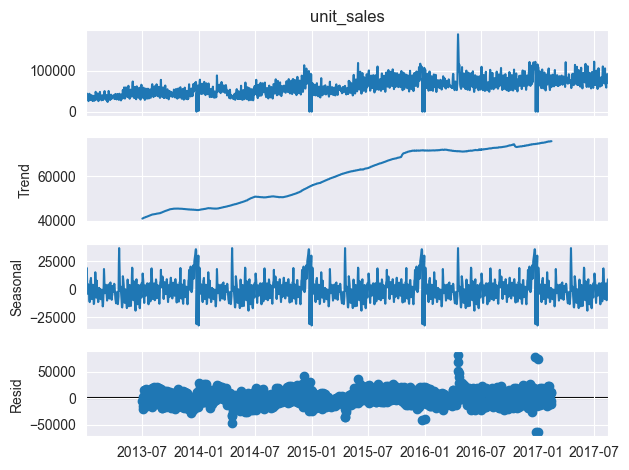

In [68]:
#Seasonal Decomposition plots
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(sales_guayas, model='additive', period=365)
result.plot()
plt.show()

#### Examining the Impact of Holidays.

In [69]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


In [70]:
# Merging df_train data with holidays
df_train_holiday = pd.merge(df_train, df_holidays_events, on='date', how='left')

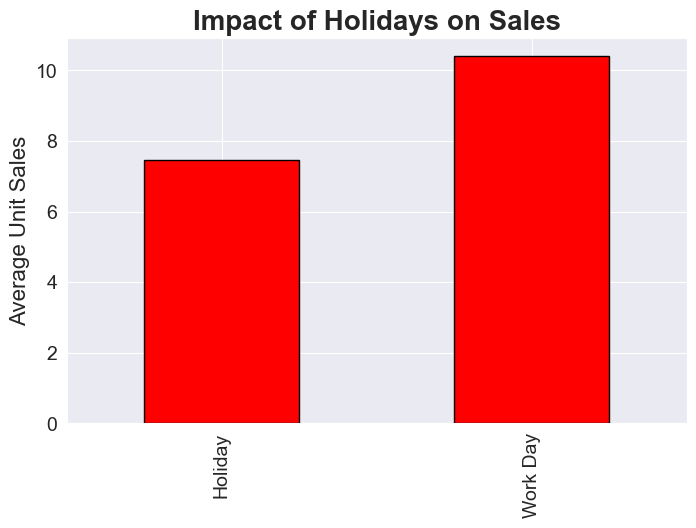

In [71]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='red', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Analyzing Perishable Items


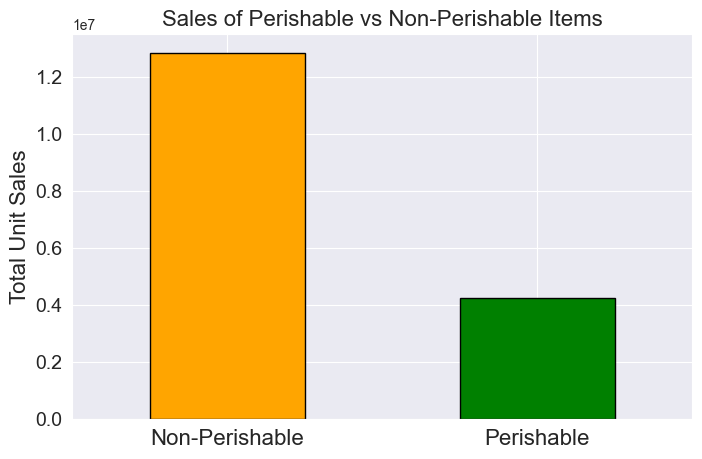

In [72]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(8,5))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1],
    labels=['Non-Perishable', 'Perishable'],
    fontsize=16,
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

#### Store-Level or Item-Level EDA in Guayas


In [74]:
# Top selling stores in Guayas. This helps decide if some stores or items behave very differently.
top_stores = df_train.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(5)

# Top selling items
top_items = df_train.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False).head(5)

print(top_stores)
print(top_items)

store_nbr
44    1098609.527
45     897662.935
47     872651.028
46     806579.485
3      796588.899
Name: unit_sales, dtype: float64
item_nbr
807493     173747.000
364606     146728.000
1047679    145013.000
819932     119597.000
584028     110759.603
Name: unit_sales, dtype: float64
